
计算Attention Pooling的输出为值的加权和：
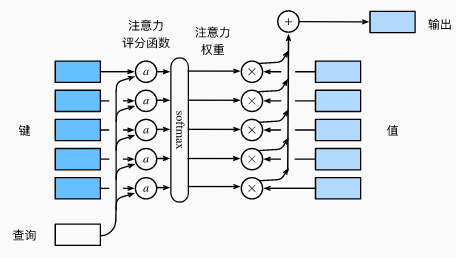
用数学语言来描述：
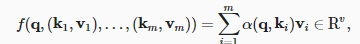
其中查询 q 和键 ki 的注意力权重（标量） 是通过注意力评分函数 a  将两个向量映射成标量， 再经过softmax运算得到的
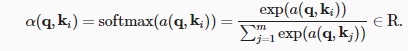

1. 掩蔽softmax操作
2. additive attention
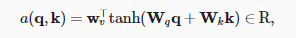
3. scaled dot-product attention
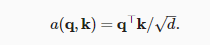
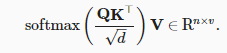
4. 小结

In [4]:
import math
import torch
from torch import nn
import dltools

In [5]:
# 任何超出有效长度的位置都被掩蔽并置为0
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = dltools.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [7]:
a = torch.rand(2, 2, 4)
print(a)
masked_softmax(a, torch.tensor([2, 3]))

tensor([[[0.0502, 0.6247, 0.3166, 0.3900],
         [0.4697, 0.8154, 0.9631, 0.7301]],

        [[0.6059, 0.9970, 0.1514, 0.9361],
         [0.8409, 0.3019, 0.2977, 0.7043]]])


tensor([[[0.3602, 0.6398, 0.0000, 0.0000],
         [0.4144, 0.5856, 0.0000, 0.0000]],

        [[0.3212, 0.4749, 0.2039, 0.0000],
         [0.4621, 0.2695, 0.2684, 0.0000]]])

In [8]:
# additive attention
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        print(queries.shape,keys.shape,values.shape)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        print(queries.shape,keys.shape,values.shape)
        features = queries.unsqueeze(2) + keys.unsqueeze(1) #整合维度 2 1 1 8   2 1 10 8
        print("****")
        print(queries.unsqueeze(2).shape,keys.unsqueeze(1).shape)
        print("****")
        print(features.shape)
        features = torch.tanh(features)
        print(features.shape)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        print(scores.shape)
        self.attention_weights = masked_softmax(scores, valid_lens)
        print("权重的形状")
        print(self.attention_weights.shape)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)  # 2 1 10 2 10 4  → 2 1 4

In [9]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

torch.Size([2, 1, 20]) torch.Size([2, 10, 2]) torch.Size([2, 10, 4])
torch.Size([2, 1, 8]) torch.Size([2, 10, 8]) torch.Size([2, 10, 4])
****
torch.Size([2, 1, 1, 8]) torch.Size([2, 1, 10, 8])
****
torch.Size([2, 1, 10, 8])
torch.Size([2, 1, 10, 8])
torch.Size([2, 1, 10])
权重的形状
torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

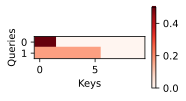

In [10]:
dltools.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),xlabel='Keys', ylabel='Queries')

In [11]:
# scaled dot-product attention
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d) 2 1 2
    # keys的形状：(batch_size，“键－值”对的个数，d) 2 10 2
    # values的形状：(batch_size，“键－值”对的个数，值的维度) 2 10 4
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d) # 2 1 10
        print(scores.shape)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)# 2 1 10 x 2 10 4 → 2 1 4

In [13]:
queries = torch.normal(0, 1, (2, 1, 2))
print(queries.shape)
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

torch.Size([2, 1, 2])
torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

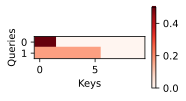

In [14]:
dltools.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),xlabel='Keys', ylabel='Queries')